<a href="https://colab.research.google.com/github/Achutha2207/reddit-nlp-project/blob/main/reddit_nlp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Fetching Reddit posts...
Cleaning text...
Generating WordCloud...


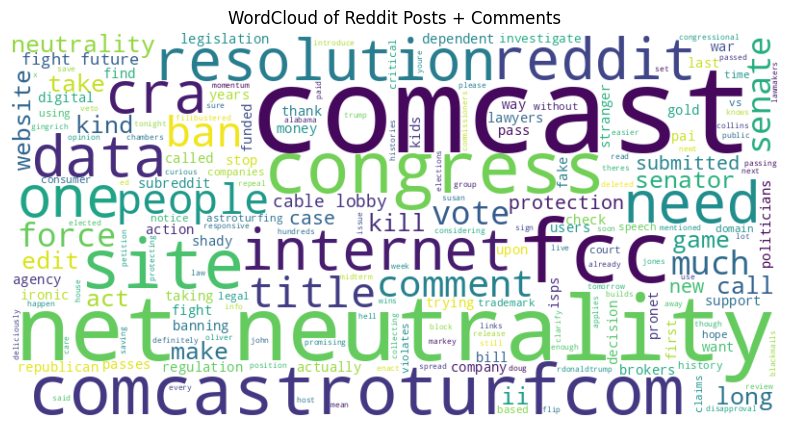


Top Bigrams:
net neutrality: 10
cable lobby: 3
fight future: 3
way force: 2
agency decision: 2
congress passes: 2
passes legislation: 2
edit thank: 2
pronet neutrality: 2
funded cable: 2

Top Trigrams:
congress passes legislation: 2
funded cable lobby: 2
title ii based: 2
ii based net: 2
based net neutrality: 2
net neutrality protections: 2
companies like comcast: 2
hundreds subreddits considering: 1
subreddits considering banning: 1
considering banning links: 1


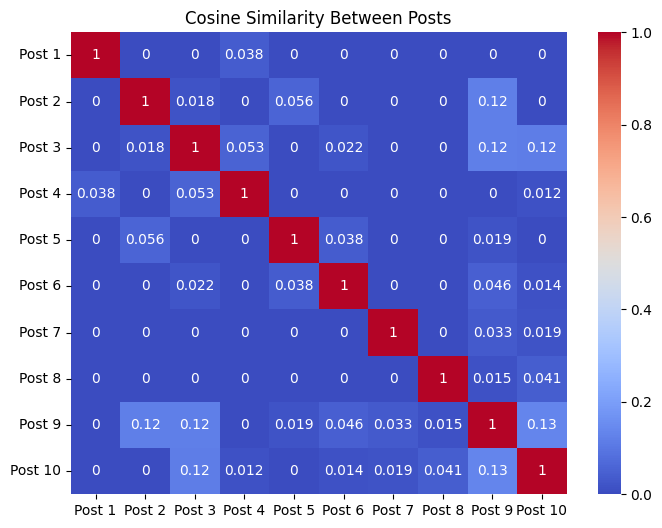

LDA Topic Modeling

Topic 1:
kids, game, resolution, cra, make, wants, targeted, article, usa, advertising

Topic 2:
reddit, data, banning, congress, neutrality, deleted, hundreds, subreddits, links, considering


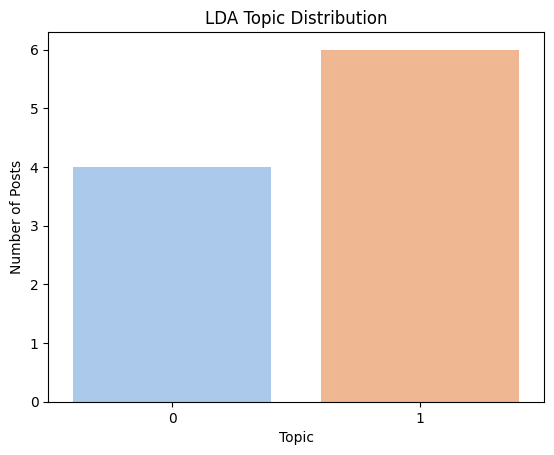

KMeans Clustering


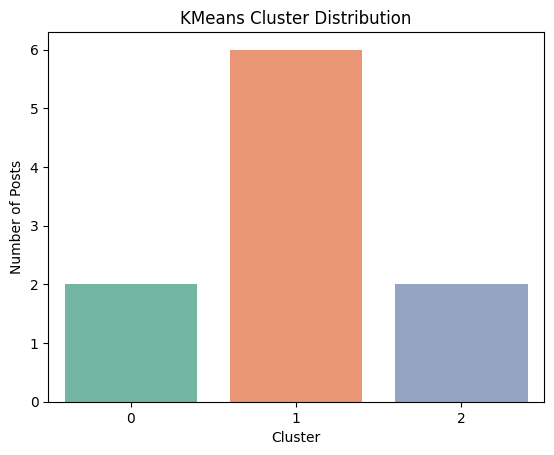

Performing Sentiment Analysis...


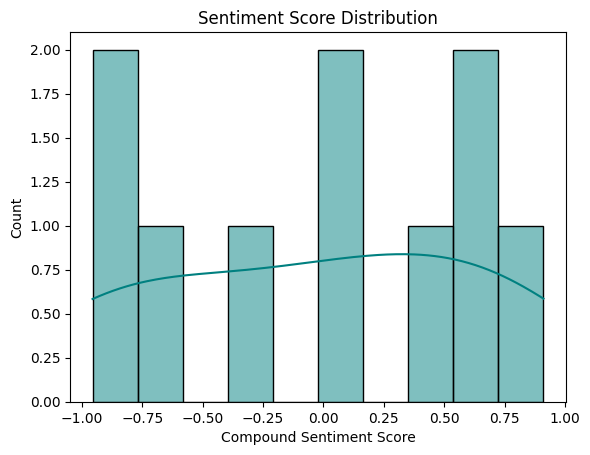


Sentiment Summary:
Average Compound Score: -0.027
Total Posts Analyzed: 10
Positive Posts: 4 (40.0%)
Negative Posts: 4 (40.0%)
Neutral Posts: 2 (20.0%)


In [5]:

!pip install praw wordcloud seaborn scikit-learn nltk --quiet

import praw
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import logging
logging.getLogger("praw").setLevel(logging.CRITICAL)

nltk.download('stopwords')
nltk.download('vader_lexicon')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import logging
import warnings

# Suppress PRAW async warnings
logging.getLogger("praw").setLevel(logging.CRITICAL)

# Suppress FutureWarnings from seaborn/matplotlib
warnings.filterwarnings("ignore", category=FutureWarning)


#  Reddit API
reddit = praw.Reddit(
    client_id="Gf_17cn2CDwW9kDzd7oxAQ",
    client_secret="IGXf8ThMV1Kpt1lPnw0iZ3tM9FxPBg",
    username="Avidus_Infinis",
    password="Achutha@222",
    user_agent="script:myfirstredditbot:v0.1 (by /u/Avidus_Infinis)"
)

#  Fetch posts
print("Fetching Reddit posts...")
posts = []
for post in reddit.subreddit("technology").top(limit=10):
    try:
        post_text = post.title + " " + (post.selftext or "")
        post.comments.replace_more(limit=0)
        comments = " ".join([c.body for c in post.comments[:1]])
        posts.append(post_text + " " + comments)
    except:
        continue

#  Clean text
print("Cleaning text...")
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

def clean(text):
    text = re.sub(r"http\S+|[^a-zA-Z\s]", "", text).lower()
    words = tokenizer.tokenize(text)
    return ' '.join(w for w in words if w not in stop_words)

cleaned = [clean(p) for p in posts]

#  WordCloud
print("Generating WordCloud...")
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(cleaned))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Reddit Posts + Comments")
plt.show()

#  Top N-Grams
def get_top_ngrams(corpus, ngram_range=(2, 2), n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

print("\nTop Bigrams:")
for gram, freq in get_top_ngrams(cleaned, (2, 2)):
    print(f"{gram}: {freq}")

print("\nTop Trigrams:")
for gram, freq in get_top_ngrams(cleaned, (3, 3)):
    print(f"{gram}: {freq}")

#TF-IDF and Cosine Similarity
tfidf = TfidfVectorizer(max_df=0.9, min_df=1, max_features=1000, stop_words='english')
X = tfidf.fit_transform(cleaned)
cos_sim = cosine_similarity(X[:10])
plt.figure(figsize=(8, 6))
sns.heatmap(cos_sim, annot=True, cmap='coolwarm',
            xticklabels=[f'Post {i+1}' for i in range(10)],
            yticklabels=[f'Post {i+1}' for i in range(10)])
plt.title("Cosine Similarity Between Posts")
plt.show()

# LDA Topic Modeling
print("LDA Topic Modeling")
lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda_topics = lda.fit_transform(X)
terms = tfidf.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"\nTopic {idx+1}:")
    print(", ".join([terms[i] for i in topic.argsort()[:-11:-1]]))

sns.countplot(x=lda_topics.argmax(axis=1), palette="pastel")
plt.title("LDA Topic Distribution")
plt.xlabel("Topic")
plt.ylabel("Number of Posts")
plt.show()

# KMeans Clustering
print("KMeans Clustering")
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
sns.countplot(x=kmeans_labels, palette="Set2")
plt.title("KMeans Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Posts")
plt.show()

#Sentiment Analysis
print("Performing Sentiment Analysis...")
sia = SentimentIntensityAnalyzer()
scores = [sia.polarity_scores(t)["compound"] for t in cleaned]
labels = ["Positive" if s > 0.05 else "Negative" if s < -0.05 else "Neutral" for s in scores]

#  Sentiment Distribution
sns.histplot(scores, bins=10, kde=True, color='teal')
plt.title("Sentiment Score Distribution")
plt.xlabel("Compound Sentiment Score")
plt.ylabel("Count")
plt.show()

#  Summary
print("\nSentiment Summary:")
avg = sum(scores) / len(scores)
pos = labels.count("Positive")
neg = labels.count("Negative")
neu = labels.count("Neutral")
print(f"Average Compound Score: {avg:.3f}")
print(f"Total Posts Analyzed: {len(scores)}")
print(f"Positive Posts: {pos} ({(pos/len(scores))*100:.1f}%)")
print(f"Negative Posts: {neg} ({(neg/len(scores))*100:.1f}%)")
print(f"Neutral Posts: {neu} ({(neu/len(scores))*100:.1f}%)")
